# Deep Learning and Neural Network - Question 1
## Arian Firoozi - 810100196
## Arman Majidi - 810100205

# Outline
- [ 0 - Packages ](#0)
- [ 1 - Data Loading ](#1)
- [ 2 - Data Preparation ](#2)
- [ 3 - Data Augmentation ](#3)
- [ 4 - Optimizers, Metrics and Loss Function ](#4)
- [ 5 - Model Implementation ](#5)
- [ 6 - Model Training ](#6)
- [ 7 - Model Evaluation ](#7)

---

<a name="0"></a>
## 0 - Packages 

First, let's run the cell below to import all the packages.
- [numpy](https://numpy.org) is the fundamental package for working with matrices in Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [seanborn](https://seaborn.pydata.org) is a Python data visualization library based on matplotlib.
- [tensorflow](https://tensorflow.org) is an end-to-end platform for machine learning.
- [scikit-learn](https://scikit-learn.org) is a Python module for machine learning.
- [albumentations](https://albumentations.ai) is a computer vision tool that boosts the performance of deep convolutional neural networks.
- [tifffile](https://pypi.org/project/tifffile) is Python library to store NumPy arrays in TIFF (Tagged Image File Format) files, and read image and metadata from TIFF-like files used in bioimaging.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import kagglehub
import albumentations as A
import tifffile
from tensorflow.keras.optimizers import Adam

import sys
sys.path.append('/kaggle/input/functions-for-ca3/')
from dataset_loader import *
from show_random_images import *
from image_augmentation import *
from metrics import *
from unet_vgg16 import *
from accuracy_loss_plot import *

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('INFO')

---

<a name="1"></a>
## 1 - Data Loading

In [3]:
dataset_path = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"

---

<a name="2"></a>
## 2 - Data Preparation

In [4]:
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = dataset_loader(dataset_path)

Dataset loaded into numpy arrays successfully!


In [5]:
print(f"""Training: X size -> {X_train.shape} and Y size -> {Y_train.shape}
Validation: X size -> {X_val.shape} and Y size -> {Y_val.shape}
Test: X size -> {X_test.shape} and Y size -> {Y_test.shape}""")

Training: X size -> (3143, 256, 256, 3) and Y size -> (3143, 256, 256)
Validation: X size -> (393, 256, 256, 3) and Y size -> (393, 256, 256)
Test: X size -> (393, 256, 256, 3) and Y size -> (393, 256, 256)


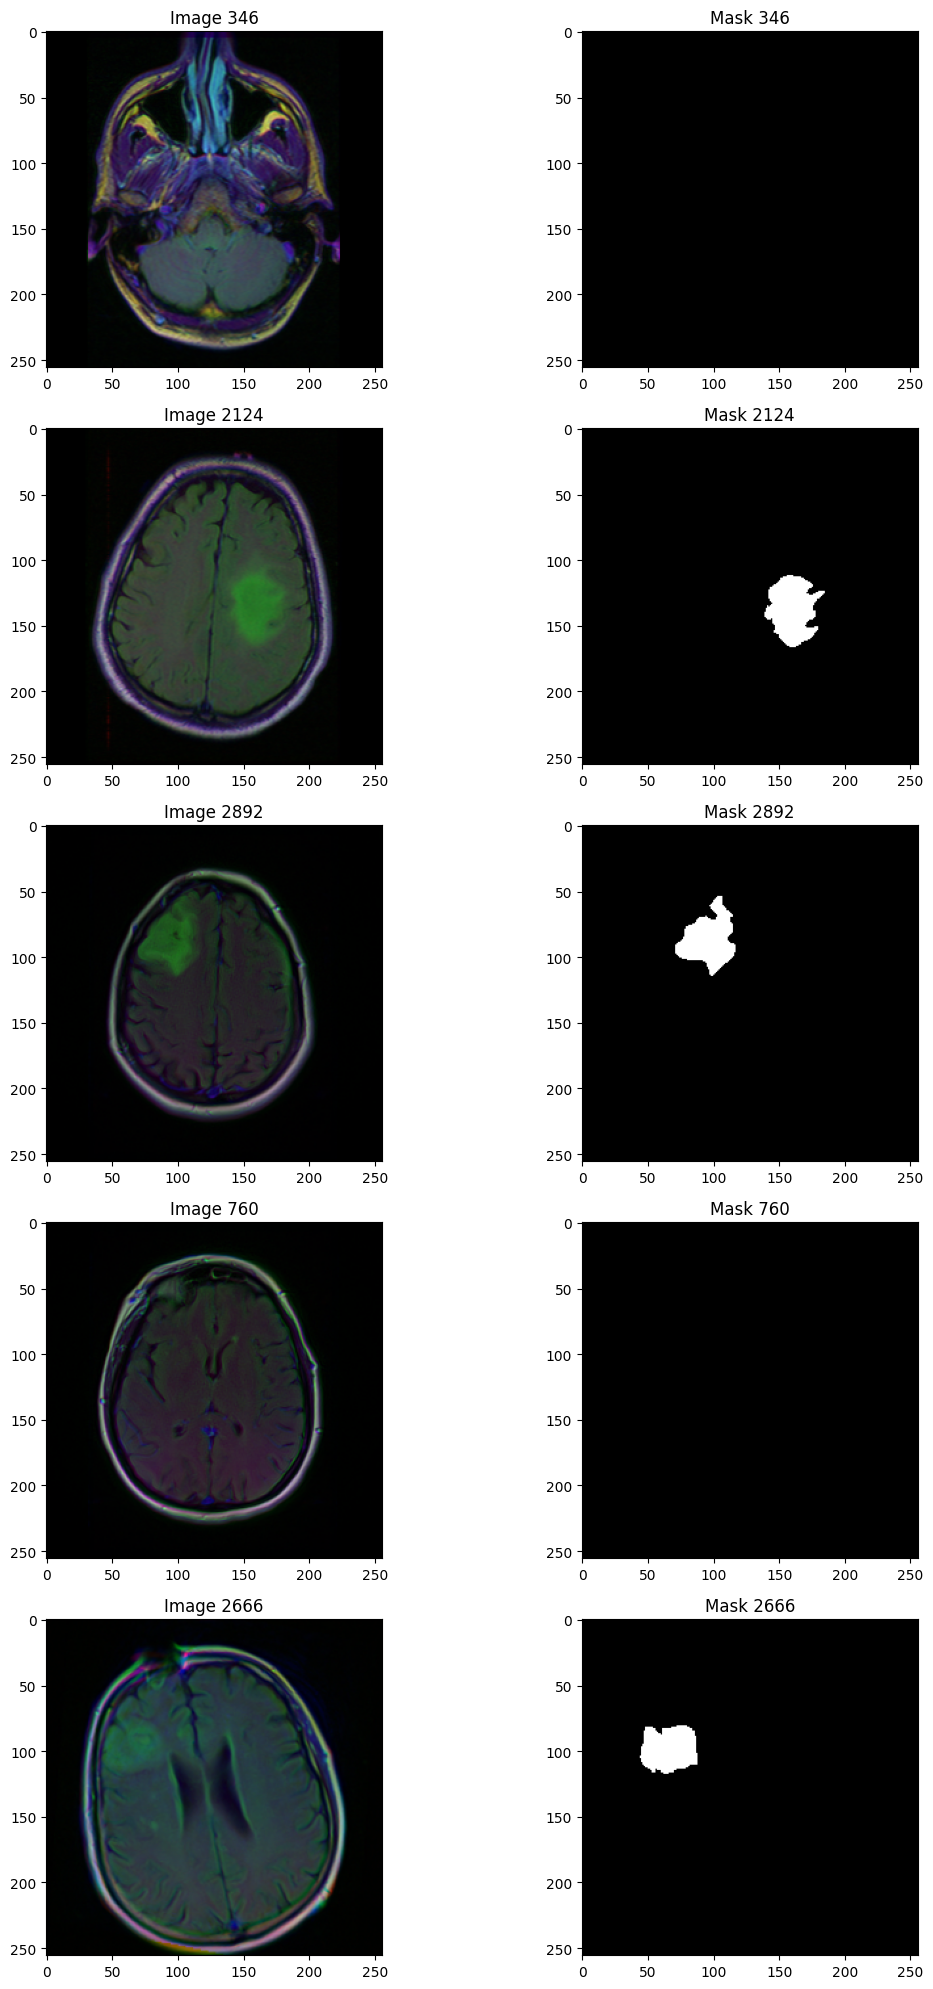

In [6]:
show_random_images(X_train, Y_train)

---

<a name="3"></a>
## 3 - Data Augmentation

In [7]:
transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.25),
    A.HueSaturationValue(p=0.25),
])

In [8]:
num_augmentations = 1
X_train, Y_train = image_augmentation(X_train, Y_train, transform, num_augmentations=num_augmentations)

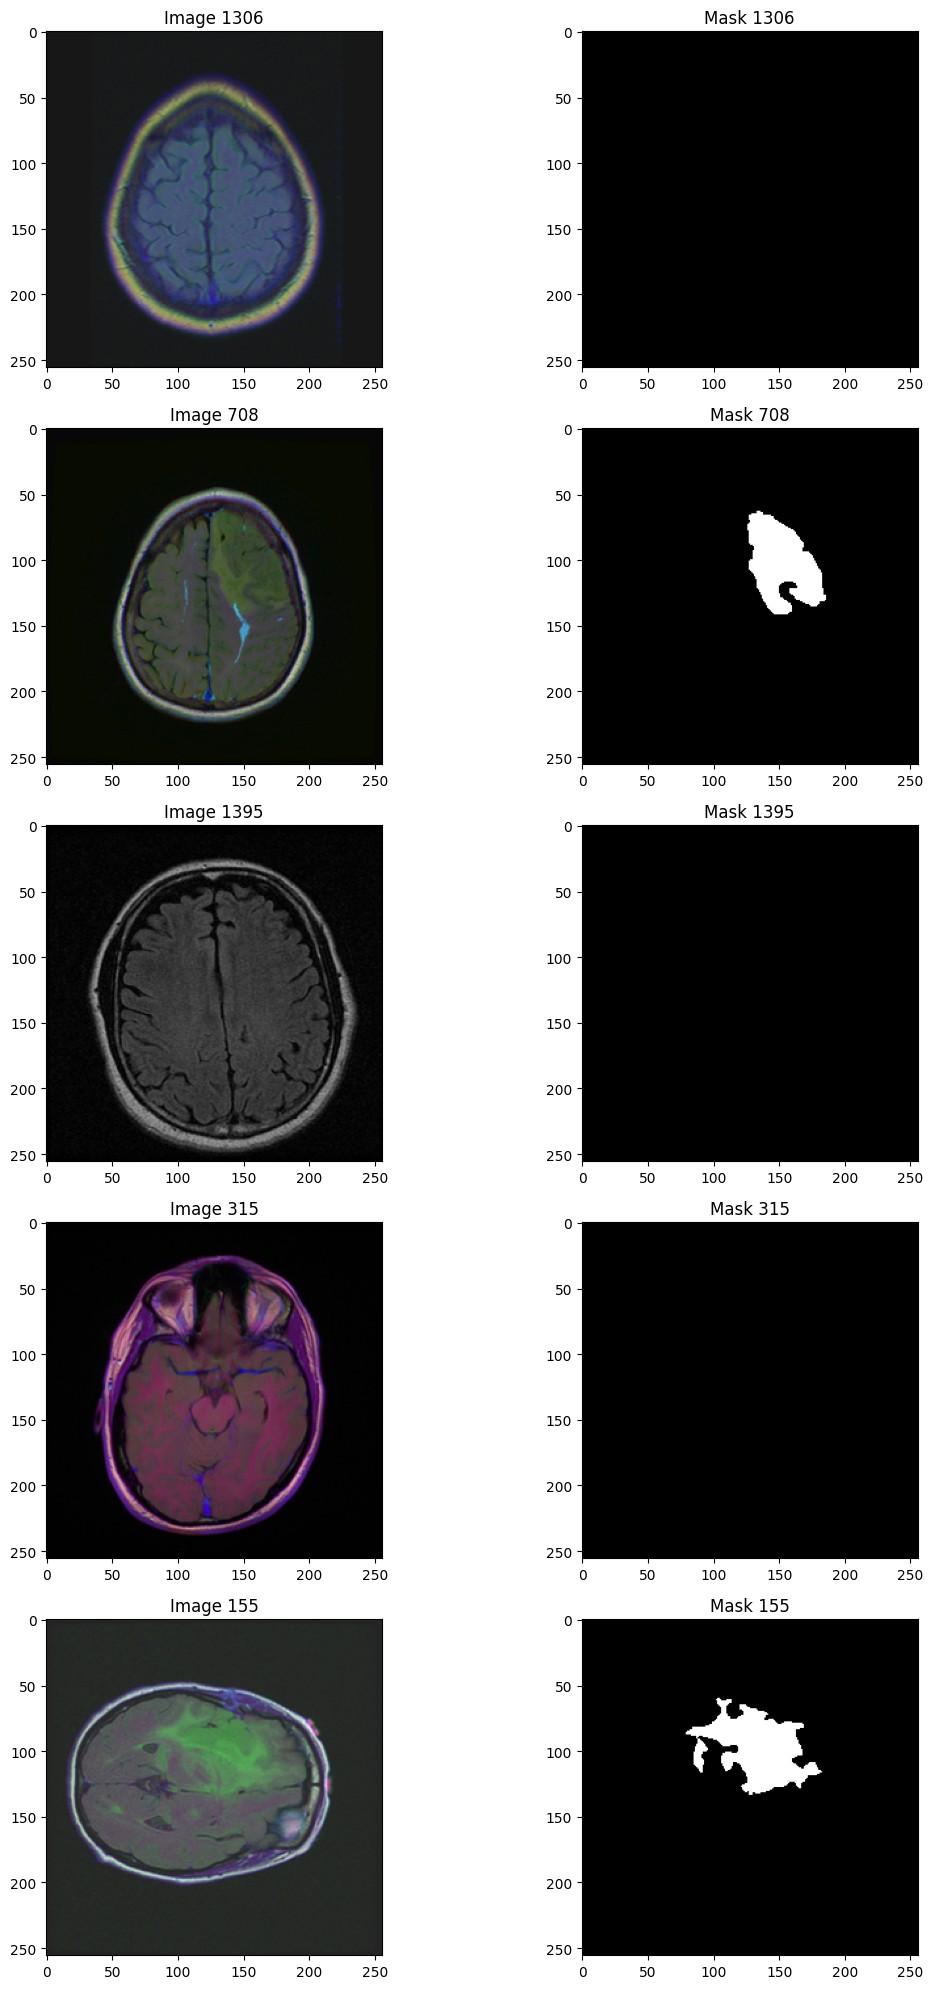

In [9]:
show_random_images(X_train, Y_train)

---

<a name="4"></a>
## 4 - Optimizers, Metrics and Loss Function

In [10]:
epoches = 20
batch_size = 32
optimizer = Adam(learning_rate=1e-4)
loss = dice_loss
metrics = [iou_metric, dice_coefficient, 'accuracy']

---

<a name="5"></a>
## 5 - Model Implementation

In [11]:
input_shape = X_train[0].shape
UNet_VGG16 = unet_vgg16(input_shape=input_shape)
UNet_VGG16.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 256,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 128,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 128,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 128,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 64,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 64,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 64,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 64,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 32,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 32,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 32,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 32,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 16, 16,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 16, 16,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 16, 16,    │  2,359,808 │ block5_conv1[0][

 Total params: 25,518,145 (97.34 MB)

 Trainable params: 10,803,457 (41.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

---

<a name="6"></a>
## 6 - Model Training

In [12]:
UNet_VGG16.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [13]:
Y_train = (Y_train / 255).astype(np.float32)
Y_val = (Y_val / 255).astype(np.float32)
Y_test = (Y_test / 255).astype(np.float32)

In [14]:
hist = UNet_VGG16.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epoches, batch_size=batch_size)

Epoch 1/20


I0000 00:00:1733342136.466646    7927 service.cc:145] XLA service 0x7be940004e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733342136.466776    7927 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733342188.419556    7927 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


99/99 ━━━━━━━━━━━━━━━━━━━━ 123s 682ms/step - accuracy: 0.9707 - dice_coefficient: 0.4208 - iou_metric: 0.2892 - loss: 0.5792 - val_accuracy: 0.9958 - val_dice_coefficient: 0.7166 - val_iou_metric: 0.5686 - val_loss: 0.2898
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 43s 439ms/step - accuracy: 0.9950 - dice_coefficient: 0.7383 - iou_metric: 0.5897 - loss: 0.2617 - val_accuracy: 0.9967 - val_dice_coefficient: 0.7720 - val_iou_metric: 0.6355 - val_loss: 0.2348
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 43s 439ms/step - accuracy: 0.9960 - dice_coefficient: 0.7827 - iou_metric: 0.6520 - loss: 0.2173 - val_accuracy: 0.9970 - val_dice_coefficient: 0.8160 - val_iou_metric: 0.6929 - val_loss: 0.1837
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 43s 439ms/step - accuracy: 0.9966 - dice_coefficient: 0.8257 - iou_metric: 0.7067 - loss: 0.1744 - val_accuracy: 0.9972 - val_dice_coefficient: 0.8268 - val_iou_metric: 0.7091 - val_loss: 0.1761
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 43s 439ms/step - accuracy: 0.9972 - dice

---

<a name="7"></a>
## 7 - Model Evaluation

#### ◆ Accuaracy, Loss, IoU and Dice Coefficient Plot

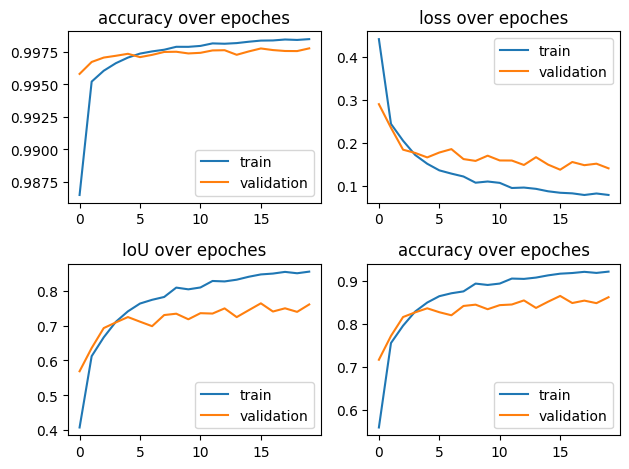

In [15]:
accuracy_loss_plot(hist)

#### ◆ Plot 10 Picture of Results

In [16]:
Y_pred = UNet_VGG16.predict(X_test, verbose=0)

np.max(Y_pred)

1.0

In [17]:
Y_pred[Y_pred < 0.5] = 0
Y_pred[Y_pred >= 0.5] = 255
Y_test = (Y_test * 255).astype(np.uint8)
Y_pred = (Y_pred * 255).astype(np.uint8)

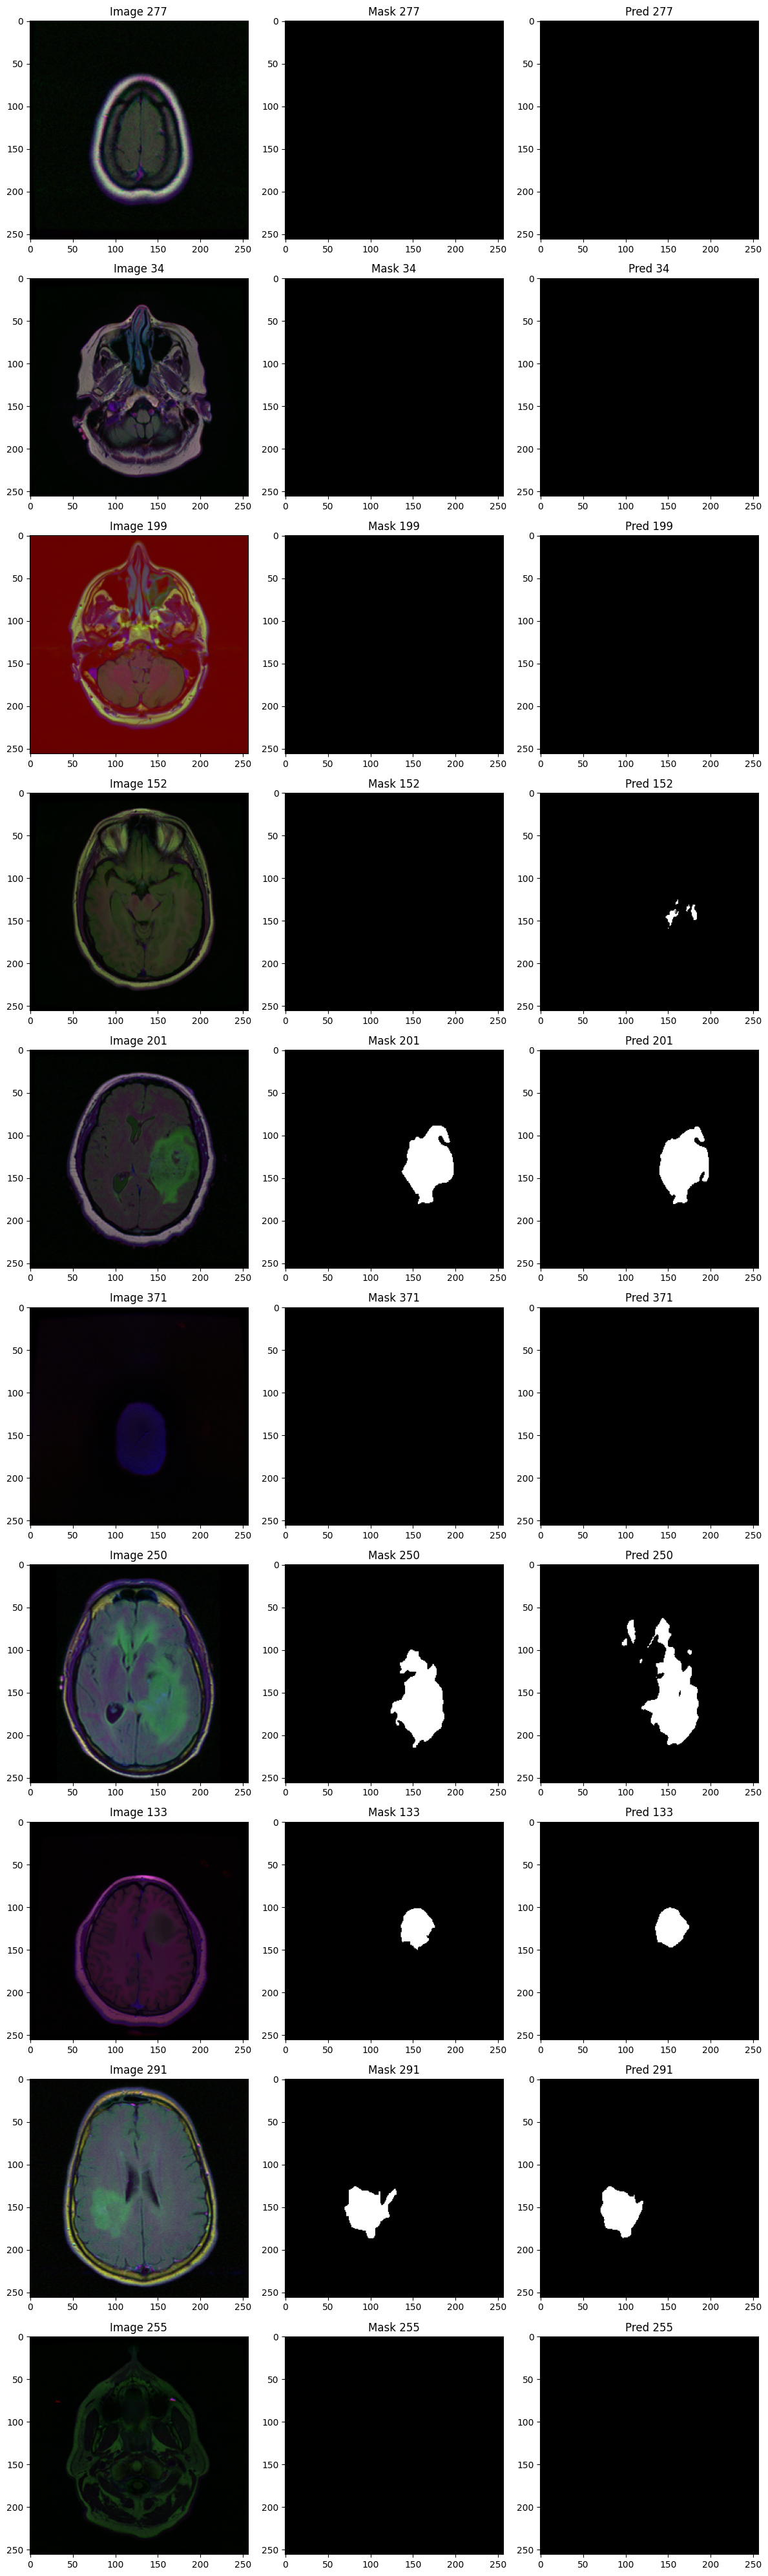

In [18]:
show_random_images(X_test, Y_test, predictions=Y_pred, num_samples=10, label_flag=1)

---